## Importing Necessary Libraries

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
print(os.listdir("./sign-language-mnist/"))

['amer_sign3.png', 'sign_mnist_train.csv', 'sign_mnist_train', 'american_sign_language.PNG', 'sign_mnist_test', 'amer_sign2.png', 'sign_mnist_test.csv']


In [49]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import cv2

## Exploratory Analysis of Training Data

Dataset source : https://www.kaggle.com/datamunge/sign-language-mnist

In [3]:
data = pd.read_csv('./sign-language-mnist/sign_mnist_train.csv')
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [4]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 27455
Number of pixels in each image: 784


In [6]:
y = data.iloc[:, :1].values.flatten()
print('Labels:\n', y)
print('Shape of Labels:', y.shape)

Labels:
 [ 3  6  2 ... 18 17 23]
Shape of Labels: (27455,)


In [7]:
a = np.arange(1, 11,3)

In [8]:
np.random.shuffle(a)

In [9]:
x,y

(array([[107, 118, 127, ..., 204, 203, 202],
        [155, 157, 156, ..., 103, 135, 149],
        [187, 188, 188, ..., 195, 194, 195],
        ...,
        [174, 174, 174, ..., 202, 200, 200],
        [177, 181, 184, ...,  64,  87,  93],
        [179, 180, 180, ..., 205, 209, 215]]),
 array([ 3,  6,  2, ..., 18, 17, 23]))

In [10]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [11]:
def display_images(data, no_of_rows, no_of_cols):
    x, y = data
    fig, axes = plt.subplots(no_of_rows, no_of_cols)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

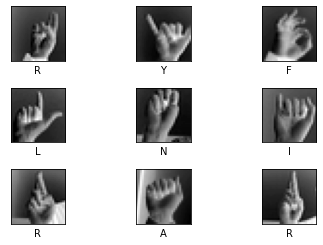

In [12]:
display_images(next_batch(9, x, y), 3, 3)

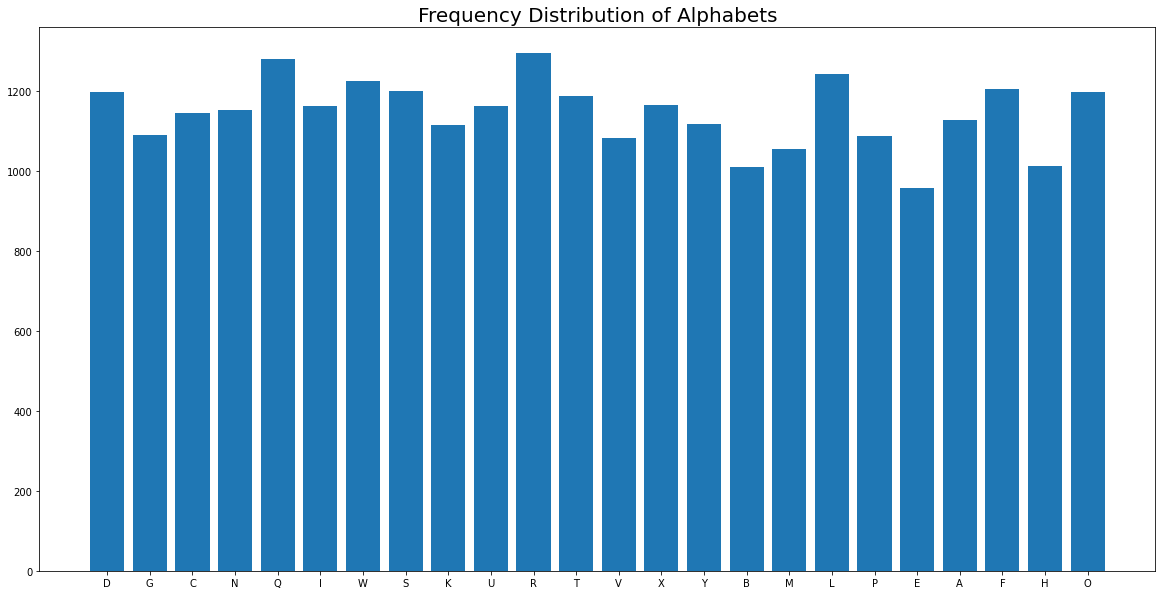

In [13]:
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
labels = [chr(i + 65) for i in z.keys()]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Alphabets', fontsize = 20)
plt.show()

In [15]:
x_rotated = []
for im in tqdm(x):
    r = im.reshape(28,28)
    for i in range(len(r)):
        r[i] = np.array(list(r[i])[::-1])
    x_rotated.append(r)

100%|██████████| 27455/27455 [00:15<00:00, 1786.82it/s]


In [21]:
for i in tqdm(range(len(x_rotated))):
    x_rotated[i] = x_rotated[i].flatten()

100%|██████████| 27455/27455 [00:00<00:00, 89455.42it/s]


In [27]:
x = np.array(list(x)+list(x_rotated))
x.shape

(54910, 784)

In [31]:
y = np.array(list(y)+list(y))
y.shape

(54910,)

In [34]:
def one_hot_encode(y):
    return np.eye(24)[y-1]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (54910, 24)


## Building the Convolutional Neural Network

In [32]:
# Training Parameters
learning_rate = 0.001
epochs = 1000
batch_size = 128
display_step = 100

In [33]:
# Neural Network Hyperparameters
n_input = 784
n_classes = 25
dropout = 0.75

In [125]:
# Placeholders
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [19]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [20]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [21]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [22]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [23]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [24]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [26]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [27]:
init = tf.global_variables_initializer()

## Training the Neural Network

In [35]:
x = x/255

In [37]:
x

array([[0.6627451 , 0.66666667, 0.66666667, ..., 0.62745098, 0.59215686,
        0.55686275],
       [0.42352941, 0.36078431, 0.54117647, ..., 0.37254902, 0.45490196,
        0.52941176],
       [0.3254902 , 0.30196078, 0.25882353, ..., 0.51764706, 0.65098039,
        0.77647059],
       ...,
       [0.61176471, 0.61960784, 0.62745098, ..., 0.85098039, 0.85098039,
        0.85098039],
       [0.69411765, 0.70196078, 0.70980392, ..., 0.52941176, 0.52941176,
        0.53333333],
       [0.15294118, 0.11764706, 0.18431373, ..., 0.42745098, 0.34509804,
        0.37647059]])

In [38]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (36789, 784)
y train shape (36789, 24)
X test shape (18121, 784)
y test shape (18121, 24)


In [29]:
saver = tf.train.Saver()

In [30]:
sess = tf.Session()

In [31]:
# with tf.Session() as sess:
# Running Initializer
sess.run(init)
cost_hist, acc_hist = [], []
for epoch in range(1, epochs + 1):
    _x, _y = next_batch(batch_size, X_train, y_train)
    # Running Optimizer
    sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
    if epoch % display_step == 0:
        # Calculating Loss and Accuracy on the current Epoch
        loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
        loss = sum(loss)
        cost_hist.append(loss)
        acc_hist.append(acc)
        print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
print('-' * 50)
print('\nOptimization Finished\n')
print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_train,
                                                       Y : y_train,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')
print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                               feed_dict = {
                                                   X : X_test,
                                                   Y : y_test,
                                                   keep_prob : 1.0
                                               }) * 100) + ' %')
saver.save(sess, './basic_cnn_model.ckpt')    

Epoch 100, Cost: 174112469.875, Accuracy: 31.25 %
Epoch 200, Cost: 41485769.875, Accuracy: 64.84375 %
Epoch 300, Cost: 12155670.0, Accuracy: 78.125 %
Epoch 400, Cost: 4375574.5625, Accuracy: 87.5 %
Epoch 500, Cost: 1456300.625, Accuracy: 92.1875 %
Epoch 600, Cost: 1264157.59375, Accuracy: 94.53125 %
Epoch 700, Cost: 1343972.625, Accuracy: 95.3125 %
Epoch 800, Cost: 964915.09375, Accuracy: 94.53125 %
Epoch 900, Cost: 907193.6875, Accuracy: 96.875 %
Epoch 1000, Cost: 321569.34375, Accuracy: 96.875 %
--------------------------------------------------

Optimization Finished

Accuracy on Training Data: 96.4934229850769 %
Accuracy on Test Data: 95.64065933227539 %


'./basic_cnn_model.ckpt'

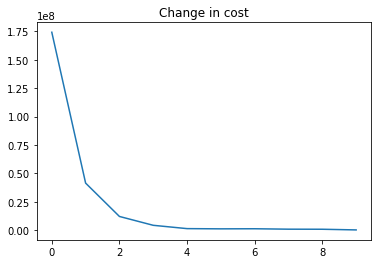

In [32]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

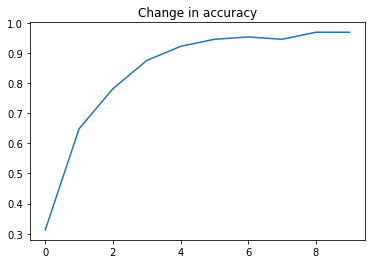

In [33]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()

## Using Keras

In [39]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
____

In [40]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [43]:
history = model.fit(X_train, y_train ,epochs = 13 , validation_data = (X_test, y_test) )

Train on 36789 samples, validate on 18121 samples
Epoch 1/13
36789/36789 [==============================] - 261s 7ms/sample - loss: 0.0086 - acc: 0.9983 - val_loss: 3.8252e-05 - val_acc: 1.0000
Epoch 2/13
36789/36789 [==============================] - 257s 7ms/sample - loss: 0.0084 - acc: 0.9982 - val_loss: 9.1834e-04 - val_acc: 0.9996
Epoch 3/13
36789/36789 [==============================] - 260s 7ms/sample - loss: 0.0089 - acc: 0.9983 - val_loss: 0.0114 - val_acc: 0.9962
Epoch 4/13
36789/36789 [==============================] - 261s 7ms/sample - loss: 0.0076 - acc: 0.9983 - val_loss: 0.0340 - val_acc: 0.9900
Epoch 5/13
36789/36789 [==============================] - 261s 7ms/sample - loss: 0.0041 - acc: 0.9993 - val_loss: 0.1133 - val_acc: 0.9719
Epoch 6/13
36789/36789 [==============================] - 262s 7ms/sample - loss: 0.0107 - acc: 0.9981 - val_loss: 7.1034e-05 - val_acc: 1.0000
Epoch 7/13
36789/36789 [==============================] - 262s 7ms/sample - loss: 0.0044 - acc: 0.

KeyboardInterrupt: 

In [47]:
model.save('model')

## Testing Predictions

In [165]:
model = keras.models.load_model('model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [166]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)         

In [44]:
pred_dict = {}
ch = 'A'
for i in range(25):
    if ch == 'J':
        ch = chr(ord(ch)+1)
    pred_dict[i] = ch
    ch = chr(ord(ch)+1)

In [45]:
def get_prediction(arr):
    arr = arr.reshape(1,28,28,1)
    return pred_dict[model.predict_classes(arr)[0]]

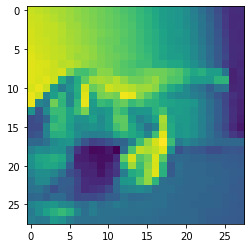

P


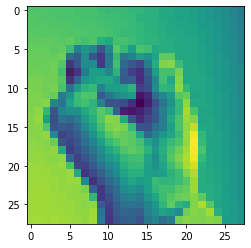

D


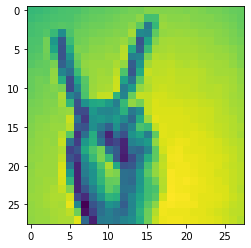

V


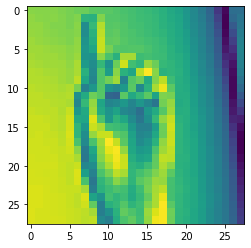

C


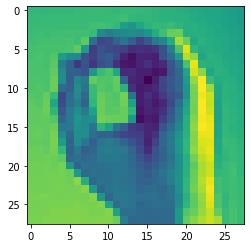

O


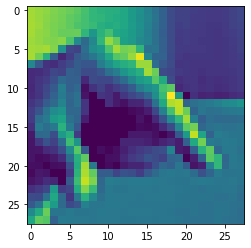

Q


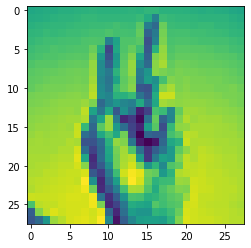

V


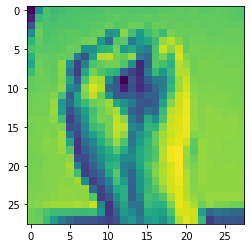

S


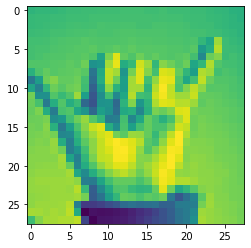

Y


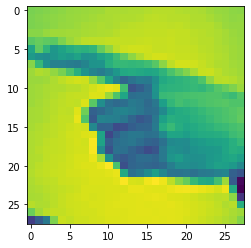

F


In [46]:
for i in range(10):
    plt.imshow(X_train[i].reshape(28,28))
    plt.show()
    print(get_prediction(X_train[i]))

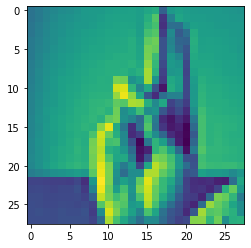

In [141]:
plt.imshow(x)

In [82]:
im = cv2.imread('captured.jpg', cv2.IMREAD_GRAYSCALE)

In [83]:
im2 = cv2.resize(im, (28,28))

In [84]:
im3 = im2/255

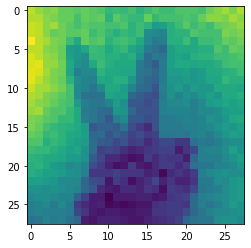

In [85]:
plt.imshow(im2/255)

In [86]:
get_prediction(im3)

'T'

In [59]:
im3[0]

array([0.10196078, 0.09411765, 0.21568627, 0.35686275, 0.38431373,
       0.09411765, 0.00784314, 0.02352941, 0.00392157, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.01568627, 0.00784314, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])